# Notebook BLOOMS MVP (497005) - FinTech Assignment

## MVP Set-up

Elements that will be included in the MVP,
1. Collecting data on charities and generating a metric for trust: using the API from Charity Navigator, it is possible to extract information on thousands of charities in the U.S. along with a rating of quality; 
2. Using the data from Charity Navigator, generate a fake id and some donation data. This fake person will be the test case for the MVP;
3. Presentation of some statistics and data to show what sort of outputs BLOOMS will be able to generate, showing the value of the product; 
4. Developing a web scraper for news data that is relevant to the fake id, highlighing another feature that is at the core of BLOOMS. 

## Load necessary packages


In [11]:
# Load the necessary packages
import pandas as pd
import numpy as np

# For data handling
import random
import string
import datetime as dt
from datetime import datetime, timedelta

# For GraphQL API requests
import requests
import json

# For web scrapers
from bs4 import BeautifulSoup

# BLOOM fake data generation 
from eth_keys import keys
import os 

# For graphs
import matplotlib.pyplot as plt

## Extracting data from API & generate sample data

Data will be extractd using the Charity Navigator API. The code is presented below. Using the `requests` library, it is possible to interact with the schemas from GraphQL. Unfortunately, all requests are blocked due to some technical error. It is possible that this is becuase of the IP-address, since a simple initial web scraper returns the same `403` error. 

The way the API works: 
- Authentication header: Stellate-API-Token
- Private API token: stl8_954f3ff2e55738166912c4a7f8ba8f5016bc1d3bfe73fe2090a4f7d215b34eec
- Base URL: https://data.charitynavigator.org
- Terms/variables: search the causes and the mission that is available in the API
- All fields in the code below are available according to Charity Navigator.

In [48]:
# Set the APIn,
base_url = 'https://data.charitynavigator.org'
api_key = 'stl8_dade875d8f6d7f8491d00fdebc45906d55b0bb84588546f9ea4b2f36b15aa1bb'

# Define the headers (use Stellate-Api-Token for authentication)
headers = {
    'Content-Type': 'application/json',
    'Stellate-Api-Token': api_key
}

# Query
query = '''
query PublicSearchFaceted($term: String!) {
    publicSearchFaceted(term: $term) {
      size
      from
      term
      result_count
      results {
        ein
        name
        mission
        organization_url
        encompass_score
        encompass_star_rating
        cause
        city
        state
        country
      }
    }
  }
'''

# List of terms to search
terms = ['human rights', 'education']

# Function to make the request
def fetch_data(term):
    variable = {
        term: term
    }
    
    payload = {
        'query': query,
        'variables': variable
    }

    response = requests.post(base_url, json=payload, headers=headers)
    
    print('Request payload')
    print(json.dumps(payload, indent=2))
    print()
    print(f'Response status code for term: {term}')
    print(response.status_code)
    print()
    print(f'Response headers for term: {term}')
    print(response.headers)
    print()

    # Check if status code 200 was returned and print results
    if response.status_code == 200: 
        data = response.json()
        print(f'Response data for term: {term}')
        print(data)
    else:
        print(f'Failed to fetch data for term: {term}: {response.status_code}')
        print(response.text)

# Loop through each term and fetch data
for term in terms:
    fetch_data(term)

Request payload
{
  "query": "\nquery PublicSearchFaceted($term: String!) {\n    publicSearchFaceted(term: $term) {\n      size\n      from\n      term\n      result_count\n      results {\n        ein\n        name\n        mission\n        organization_url\n        encompass_score\n        encompass_star_rating\n        cause\n        city\n        state\n        country\n      }\n    }\n  }\n",
  "variables": {
    "human rights": "human rights"
  }
}

Response status code for term: human rights
403

Response headers for term: human rights
{'Connection': 'keep-alive', 'Content-Length': '418', 'x-cache': 'MISS', 'retry-after': '0', 'content-type': 'text/html; charset=utf-8', 'accept-ranges': 'bytes', 'date': 'Thu, 27 Jun 2024 09:56:58 GMT', 'access-control-max-age': '600', 'access-control-expose-headers': '*', 'access-control-allow-credentials': 'true', 'vary': 'x-bypass-cache, accept-encoding', 'access-control-allow-methods': 'POST, GET, HEAD, OPTIONS', 'x-cache-type': 'Would PASS e

### Alternative 1: Charity Navigator Web Scraper

Below code shows that the IP-address might be blocked. 

In [49]:
# Define the URL
url = 'https://www.charitynavigator.org/search?pageSize=10'

# Fetch HTML content
response = requests.get(url)

# Parse HTML with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')
print(soup)


<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
 "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<html>
<head>
<title>403 Forbidden</title>
</head>
<body>
<h1>Error 403 Forbidden</h1>
<p>Forbidden</p>
<h3>Error 54113</h3>
<p>Details: cache-ams21046-AMS 1719482219 1252725533</p>
<hr/>
<p>Varnish cache server</p>
</body>
</html>



### Alternative 2: generate fake data

Instead, what we will do is generate some fake data, but first, the details will be explained for the fake user Henk. 

To showcase the MVP, some data will be generated for a fake user. The user will be called Henk Doldelydoo. Henk performs all of his transactions and donations through his payment account at the ING bank. 

His IBAN at this Dutch bank is:

In [50]:
# Name fake donor 
name_fake = 'Henk Dolelydoo'

# Generate a random Dutch IBAN 
IBAN_fake = 'NL' + str(random.randint(10,99)) + 'INGB' + ''.join(random.choice(string.digits) for i in range(10))
print(IBAN_fake) 

NL49INGB3840577268


A fake email address will be generated for Henk as follows: 

In [51]:
# Generate a random email address
email_fake = 'h.' + ''.join(random.choice('doleydoo')for i in range(8)) + '@' + 'erasmus.fake'
print(email_fake)

h.eoooydle@erasmus.fake


BLOOMS will work with the Ethereum decentralised blockchain technology for smart contracts. This means that BLOOMS basically has to create a wallet with a private key for each of its users. This operation will cost a minimal amount of money that the user will have to pay in a one-time, upfront payment. Below, we generate a random private key to illustrate this 


In [52]:
# Generate a random private key (32 bytes)
private_key = os.urandom(32)
    
# Create a keys.PrivateKey object
eth_key = keys.PrivateKey(private_key)

# Get the Ethereum address from the public key
ethereum_address = eth_key.public_key.to_checksum_address()
print(ethereum_address)

0xa47fB87A4923B66f7D9851843E984491f04B7b4b


Finally, we still have to decide on the amount Henk donates and the number of donations he makes per month. Let's say Henk makes a maximum of 3 donations a month with a total value of not more than 500 EUR. A single donation typically does not exceed 250 EUR.

To generate fake donation amounts, we created the function `donation_fake_rand`. Also, a function was created to generate a fake id for each transaction and token. 

*Please note that the donation function will not be used since the API did not return any data. Instead, the data will be faked.*

In [53]:
# Create function donation_fake_rand to generate a random donation amount 
def donation_fake_rand():
    amount = random.randint(0, 250)
    return amount

# Create function fake_id to generate a random id for donation id and token token id 
def fake_id_rand():
    id = '0x' + ''.join(random.choices(string.hexdigits.lower(), k=18))
    return id

Finally, we have to make a selection of charities to which Henk is willing to donate. The data on the charity organisations is derived from Charity Navigator. It provides a large set of charity organisations in the US. The data includes some relevant criteria for this MVP. n,

Remember that BLOOMS offers a way of tracking donations alongside information on the impact a donation makes. Charity Navigator offers a rating for each charity alongside some background information. The ratings will serve as a measure for the impact a single donation can make. This will be explained later. 

Using the Charity Navigator data, we can select a set of charities for donations based on some criteria. The criteria that were selected for Henk 
1. A minimum of a four-star rating (90+ points); 
2. A charity related to a cause of human rights, religion or health.

There are more ratings available to further extent the depth of the MVP. We will not include these for now, but for a illustration, please refer to the image below or see this website [Charity Navigator](https://www.charitynavigator.org/about-us/our-methodology/ratings/#accordion-0f1da9ef58-item-57920c7dce). 

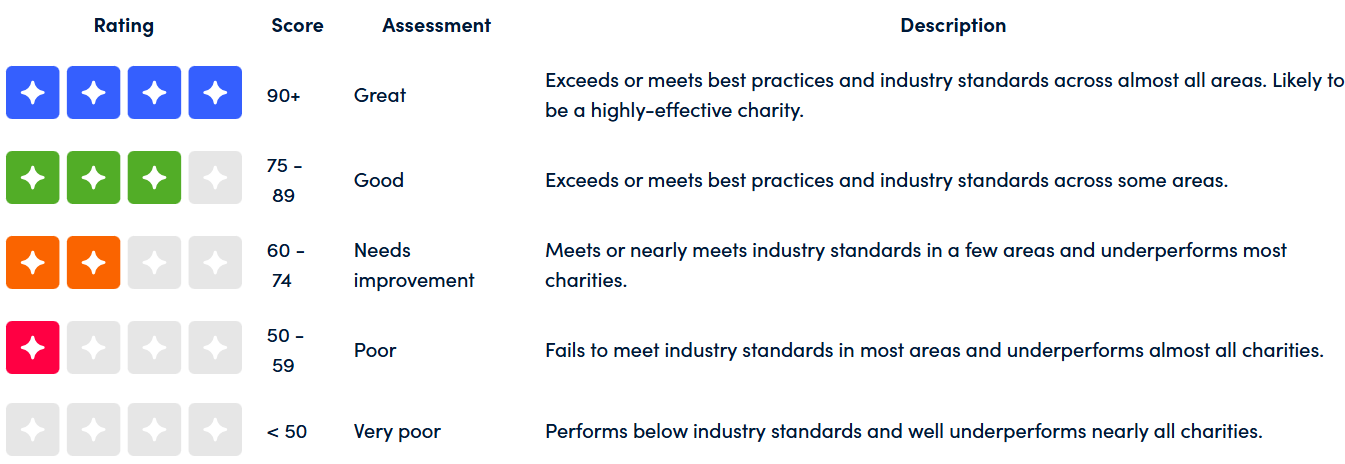

*Since the API and web scraper did not work on the Charity Navigator due to IP-address restrictions, a set of random data was generated according to the principles described above. Therefore, the steps to generate fake data for Henk and this temporary change in the MVP have been combined in the next step.*

## Data generation for a fake user
The generated data will contain the following elements 
- ```name```: Henk Dolelydoo
- ```bank_account```: random
- ```email```: random
- ```eth_address```: random
- ```charity```: from list
- ```cause```: cause 
- ```rating```: rating from charity navigator
- ```amount```: Random amount donated (between 1 and 500) with ```donation_fake_rand```
- ```currency```: currency of payment (can be crypto; in this case only USD will be considered)
- ```mode_payment```: the mode of payment used (in this case only direct bank transfer)
- ```donation_id```: Random ID with ```fake_id_rand``` to record the transaciton
- ```timestamp```: Random timestamp (2016 until now) with ```timestamp_fake_rand```
- ```token_id```: Random ID with ```fake_id_rand``` to record the token belonging to a transaction
- ```spent_status```: boolean random to indicate whether the token was spent 

The next steps will generate this fake data. Charities were taken from Charity Navigator. We assume four transactions per month, provide twelve donations, which makes three months. Next, the data was multiplied by four to create one year. Finally, the data was multiplied by three to create three years. 

A monthly payment to IJM of 150 EUR was included. Church includes a monthly donation to the local church where Henk is a member. The church donation is a general donation to all activities of that church, meaning that BLOOMS will assign a rating of 100. 

*Note that this means that the random donation amount generat.or will not be used*

In [54]:
data = {
    'charity': ['Amnesty', 'Webster', 'IJM', 'Church', 'HRW', 'GlobalGiving', 'IJM', 'Church', 
                'MexAm_Opp', 'Oregon_FB', 'IJM', 'Church'], 
    'cause': ['Human Rights', 'Education', 'Human Rights', 'Religion', 'Human Rights', 'Human Rights', 
              'Human Rights', 'Religion', 'Education', 'Basic needs', 'Human Rights', 'Religion'],
    'rating': [96, 96, 87, 100, 97, 97, 87, 100, 91, 99, 87, 100],
    'amount': [80, 50, 150, 100, 60, 25, 150, 100, 110, 75, 150, 100]
}

# With these twelve transactions (four per month), extend the data for a period of three years 
per_year_data = {
    'charity': data['charity']*12,
    'cause': data['cause']*12, 
    'rating': data['rating']*12, 
    'amount': data['amount']*12
}

# Pandas DF
data = pd.DataFrame(per_year_data)

# Add the columns name, bank_account, donor_email, donor_eth_address, donation_currency, mode_payment
data['name'] = 'Henk Dolelydoo'
data['bank_account'] = IBAN_fake
data['email'] = email_fake
data['eth_address'] = ethereum_address
data['currency'] = 'EUR'
data['mode_payment'] = 'bank transfer'

Next, we add random timestamps per month, starting three years back

In [55]:
# Define the starting daten,
start_date = datetime(2021, 4, 1)

# Initialize list to store timestamps
timestamps = []

# Generate timestamps
for _ in range(36):
    # Go to the next month
    next_month = start_date.month % 12 + 1
    next_year = start_date.year + (1 if next_month == 1 else 0)
    start_date = start_date.replace(year=next_year, month=next_month)

    # For four transactions, generate some timestamps
    for _ in range(4): 
        # A new date after a random set of days 
        days_add = random.randint(1, 28)
        new_date = start_date + timedelta(days=days_add)

        # Append to list
        timestamps.append(new_date)

# Add to the dataframe
data['timestamp'] = timestamps

Create a donation and token ID using the functions written earlier

In [56]:
# Next, for each transaction, we generate a donation id and a token idn,
tokens = []
donations = []

# Create a loop
for _ in range(144):
    token_id = fake_id_rand()
    donation_id = fake_id_rand()

    tokens.append(token_id)
    donations.append(donation_id)
    
# Add to the dataset 
data['token_id'] = tokens
data['donation_id'] = donations

Finally, set the spent status to either 0 or 1, with 1 meaning that the donation was spent by the charity. We want to see a decreasing number of 0's to reflect reality. For this, Sigmoids function will be used. 

In [57]:
# Define the sigmoid function
def sigmoid(x, midpoint, slope):
    """
    Sigmoid function to generate probabilities of 1s based on the position in the list.
    """
    return 1 / (1 + np.exp(-slope * (x - midpoint)))

# Define the function to generate a binary list
def generate_binary_list(length):
    """
    Generate a list of binary values where the number of 1s decreases smoothly from start to end.
    """
    # Initialize an empty list to store binary values
    binary_list = []

    # Define parameters for the sigmoid function
    midpoint = length / 2  # Midpoint of the list
    slope = 0.1  # Slope parameter determines how quickly the probability decreases

    # Generate binary values
    for i in range(length):
        # Calculate the probability of having 1 using the sigmoid function
        p = sigmoid(i, midpoint, slope)
        
        # Append 1 or 0 based on the probability p
        binary_list.append(np.random.choice([0, 1], p=[1-p, p]))
    
    return binary_list

# Generate a list of 144 binary values
binary_list = generate_binary_list(144)

# Reverse the list
binary_list.reverse()

# Print the generated list
print(binary_list)

# Add the binary list as 'spent' to the data
data['spent'] = binary_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


A few final steps and the data is ready: 

In [58]:
# Right order of columns
cols = ['name', 'bank_account', 'email', 'eth_address', 'charity', 'cause', 'rating', 'amount',
        'currency', 'mode_payment', 'donation_id', 'timestamp', 'token_id', 'spent']
data = data[cols]

# Make sure timestamp is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Make sure all dates are chronological in the dataset
data = data.sort_values(by='timestamp')

# Have a look at the data
print(data.info())
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 2 to 141
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   name          144 non-null    object        
 1   bank_account  144 non-null    object        
 2   email         144 non-null    object        
 3   eth_address   144 non-null    object        
 4   charity       144 non-null    object        
 5   cause         144 non-null    object        
 6   rating        144 non-null    int64         
 7   amount        144 non-null    int64         
 8   currency      144 non-null    object        
 9   mode_payment  144 non-null    object        
 10  donation_id   144 non-null    object        
 11  timestamp     144 non-null    datetime64[ns]
 12  token_id      144 non-null    object        
 13  spent         144 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(2), object(10)
memory usage: 16.3+ KB
None



,name,bank_account,email,eth_address,charity,cause,rating,amount,currency,mode_payment,donation_id,timestamp,token_id,spent
2,Henk Dolelydoo,NL49INGB3840577268,h.eoooydle@erasmus.fake,0xa47fB87A4923B66f7D9851843E984491f04B7b4b,IJM,Human Rights,87,150,EUR,bank transfer,0x57c1a0b087efdcbeaf,2021-05-07,0x6c7fdfdbd1ffb8eeca,1
3,Henk Dolelydoo,NL49INGB3840577268,h.eoooydle@erasmus.fake,0xa47fB87A4923B66f7D9851843E984491f04B7b4b,Church,Religion,100,100,EUR,bank transfer,0xfeabfbcffbbbc3b63d,2021-05-07,0xf33e5cccdbf3c2d6ba,1
1,Henk Dolelydoo,NL49INGB3840577268,h.eoooydle@erasmus.fake,0xa47fB87A4923B66f7D9851843E984491f04B7b4b,Webster,Education,96,50,EUR,bank transfer,0x937f5efd5e6a7bd594,2021-05-14,0x1bf67f9d8cbffc43ed,1
0,Henk Dolelydoo,NL49INGB3840577268,h.eoooydle@erasmus.fake,0xa47fB87A4923B66f7D9851843E984491f04B7b4b,Amnesty,Human Rights,96,80,EUR,bank transfer,0xc4ffdbaaaee5425d15,2021-05-21,0xcd82b0ed4a3d902f6b,1
4,Henk Dolelydoo,NL49INGB3840577268,h.eoooydle@erasmus.fake,0xa47fB87A4923B66f7D9851843E984491f04B7b4b,HRW,Human Rights,97,60,EUR,bank transfer,0x8e4accd0b3bbdbcb83,2021-06-07,0x143f1e8ac5eaea0aec,1


## User Interface
BLOOMS shares the impact a donor makes with his or her donations. This will be illustrated below by computing some statistics and making some graphs. Next, a web scraper for news feed will be made, specifically for IJM. A personalised news feed is one of the functions of BLOOMS. That is why it will be included in this MVP. 

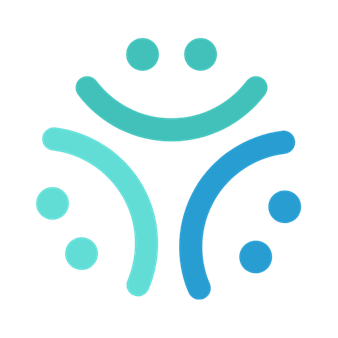

The steps below will generate some graphs and statistics to show the value of the MVP. First, a month, month-year and year column are made for plotting. Next, a few stats are printed to have a look at the data. 


In [59]:
# Create month, month-year and year columns
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

# Order the data set
data.sort_values('timestamp', inplace=True)

# Some statistics 
month_donation = data.groupby(['month'])['amount'].sum() # monthly amounts
year_donation = data.groupby(['year'])['amount'].sum() # yearly amounts

# Print
print(month_donation)
print()
print(year_donation)
print()

month
1     1305
2      990
3     1155
4     1305
5     1140
6     1005
7     1305
8     1140
9     1005
10    1305
11    1140
12    1005
Name: amount, dtype: int64

year
2021    3015
2022    4600
2023    4600
2024    1585
Name: amount, dtype: int64



### Bar plot for amount spent
It would be great if Henk could verify the total amount spent per charity. Maybe he decides that the distribution does not reflect his interests. Below, a bar plot is created to help him. 

Additionally, the graph shows the relative amount that was also spent by the charity. If the amount was spent, Henk made an impact. The grey bars show the amount donated, and the light blue bars show the relative amount that was spent by the charity. 

This could impact Henk's decision to make donations in the future to certain charities.

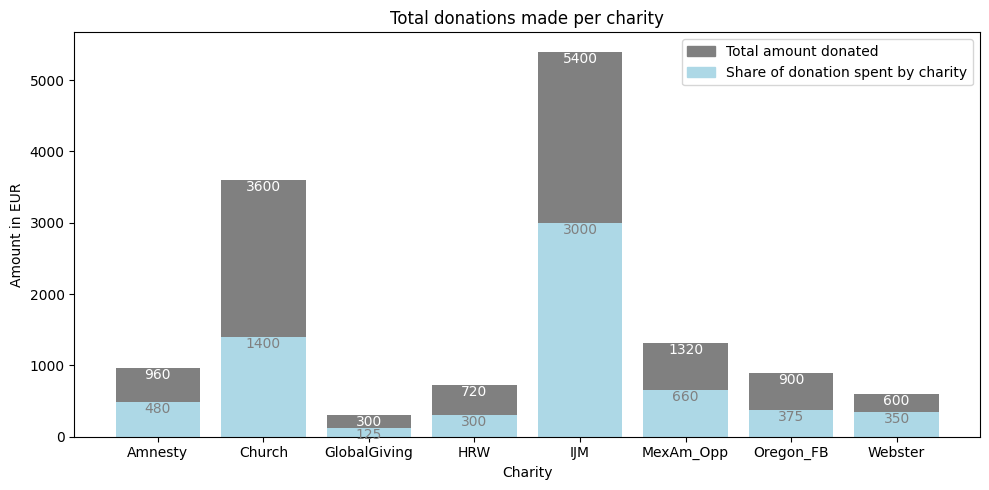

In [67]:
# Create a variable that equals 0 when spent == 0 and that equals the amount donated when spent == 1
data['spent_amount'] = data['spent'] * data['amount']

# Data for the plot 
data_plt = data.groupby(['charity'])[['amount', 'spent_amount']].sum().reset_index()

# Figure
plt.figure(figsize=(10, 5))

# Add a legend
legend_labels = ['Total amount donated', 'Share of donation spent by charity']
legend_colors = ['grey', 'lightblue']
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, loc='best')

# Plot total amounts
bars1 = plt.bar(data_plt['charity'], data_plt['amount'], color='grey')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='top', color='white')

# Plot amounts spent
bars2 = plt.bar(data_plt['charity'], data_plt['spent_amount'], color='lightblue')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='top', color='grey')

# Formatting
plt.title('Total donations made per charity')
plt.xlabel('Charity')
plt.ylabel('Amount in EUR')
plt.tight_layout()
plt.show()

### Rating statistics
Next, Henk can get insights in some interesting statistics based on the ratings 

In [68]:
# Impact per cause overall
impact_cause = data.groupby(['cause'])['rating'].mean() 
print(impact_cause)

cause
Basic needs      99.000000
Education        93.500000
Human Rights     91.833333
Religion        100.000000
Name: rating, dtype: float64


In [69]:
# The contribution Henk made in april this year 
impact_cause_year = data.groupby(['cause', 'month', 'year'])['rating'].mean()
impact_cause_year = impact_cause_year.reset_index().sort_values('month')
print(impact_cause_year[(impact_cause_year['month'] == 4) & (impact_cause_year['year'] == 2024)])

           cause  month  year  rating
47  Human Rights      4  2024    87.0
83      Religion      4  2024   100.0
20     Education      4  2024    91.0
5    Basic needs      4  2024    99.0


In [70]:
# For 2024
df_temp = data[data['year'] == 2024]
impact_2024 = df_temp.groupby('cause')['rating'].mean()
print(impact_2024)

cause
Basic needs      99.000000
Education        92.666667
Human Rights     91.142857
Religion        100.000000
Name: rating, dtype: float64


### Impact per cause
BLOOMS will also show the impact per cause over the last year. This is calculated as follows the ratings are used as a percentage to show the relative amount that is spent on the cause instead on administrative costs by the charity. This is computed for both the amount that is spent and the total donation amount. 

In a sense, the impact score is a score of efficiency and is shown for both the amounts spent by the charity as well as the total amount. 

The results are visualised in a bar plot for Henk for the last year. First we compute the impact scores. There will be one score for the total amount spent by multiplying the rating as a percentage of that amount, and one score for the amount of money that was actually spent by the charity. The share of the amount that was spent vs. the amount that was not spent is then calculated. 

In [85]:
# Impact score for total amount
data['impact_amount'] = data['amount'] * (data['rating'] / 100)
data['impact_amount_pct'] = (data['impact_amount'] / data['amount'])*100

# Impact score for amount spent
data['impact_amount_spent'] = data['spent_amount'] * (data['rating'] / 100)
data['impact_amount_spent_pct'] = (data['impact_amount_spent'] / data['spent_amount'])*100

# Filter for the last year
data_year = data[data['timestamp'].dt.date > pd.to_datetime('2023-03-30').date()]

# Data for the plot
df_impact = data.groupby(['cause'])[['impact_amount_pct', 'impact_amount_spent_pct']].mean().reset_index()
print(df_impact)

          cause  impact_amount_pct  impact_amount_spent_pct
0   Basic needs          99.000000                99.000000
1     Education          93.500000                93.692308
2  Human Rights          91.833333                91.277778
3      Religion         100.000000               100.000000


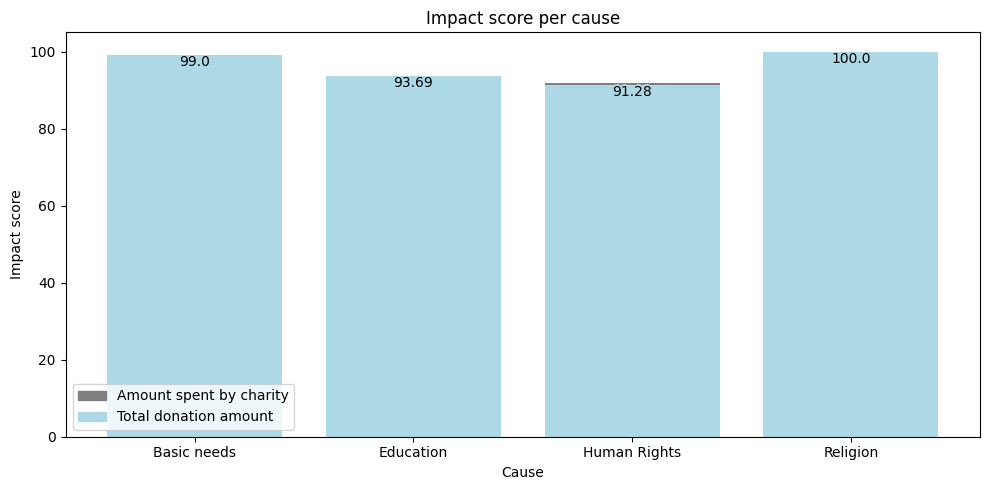

In [87]:
# Figure
plt.figure(figsize=(10, 5))

# Add a legend
legend_labels = ['Amount spent by charity', 'Total donation amount']
legend_colors = ['grey', 'lightblue']
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_patches, loc='best')

# Plot total amounts
bars1 = plt.bar(df_impact['cause'], df_impact['impact_amount_pct'], color='grey')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='top', color='lightblue')

# Plot amounts spent
bars2 = plt.bar(df_impact['cause'], df_impact['impact_amount_spent_pct'], color='lightblue')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='top')

# Formatting and print
plt.title('Impact score per cause')
plt.xlabel('Cause')
plt.ylabel('Impact score')
plt.tight_layout()
plt.show()


## Scrape News Feed IJM
Finally, we will show the technology behind the news feed feature of BLOOMS. 

IJM is a charity organisation that is especially important to Henk after he visited several countries including the Phillipines where he met some people of this charity. Because the cause of IJM is so important to Henk, BLOOMS shows relevant project updates and news publications. There are two type of messages that are interesting to Henk, these include success stories and press releases. Succes stories are intended to showcase the work of IJM to donors, so these will be included in the BLOOMS Newsfeed. 

To illustrate this, some news articles are are gathered using web scraping in the code below. 

In [95]:
URL = 'https://www.ijm.org/stories'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [101]:
import requests
from bs4 import BeautifulSoup

# Function to extract href, title, and date of articles from IJM site
def extract_ijm_news(soup): 
    articles = []
    result_articles = soup.find_all('a', class_='carousel-story carousel-story--compact small-12 medium-6 large-4 column')

    for article in result_articles: 
        href_article = article.get('href')
        title_article = article.find('h5', class_='carousel-story__head heading heading--special')
        title_text = title_article.text.strip() if title_article else 'No title found'
        date_article = article.find('div', class_='carousel-story__date')
        date_text = date_article.get_text(strip=True) if date_article else 'No date found'

        # Append to articles
        articles.append((href_article, title_text, date_text))

    return articles

# Function to get the URL of the next page
def get_next_page_url(soup):
    # Find the link to the next page
    next_page = soup.find('a', class_='pad pad--pager')  # Adjust this selector based on the actual site structure
    if next_page:
        return next_page.get('href')
    return None

# Function to fetch the last 10 articles from IJM website efficiently
def fetch_last_10_ijm(news_url_ijm, target_article_count=10):
    news = []
    url = news_url_ijm

    while len(news) < target_article_count:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')

        # Extract news from the current page
        articles = extract_ijm_news(soup)
        news.extend(articles)

        # If we have enough articles, break out of the loop
        if len(news) >= target_article_count:
            break

        # Find the next page URL
        url = get_next_page_url(soup)
        if not url:
            break

    # Return only the required number of articles
    return news[:target_article_count]

# URL of the IJM website
url = 'https://www.ijm.org/stories'

# Fetch the last 10 news articles from the URL
articles = fetch_last_10_ijm(url)

# Print the fetched articles for verification
for article in articles:
    print(f'URL: {article[0]}\nTitle: {article[1]}\nDate: {article[2]}\n')


URL: https://www.ijm.org/news/leader-inocencio-receives-highest-anti-trafficking-award-us-government-tip-report-release
Title: IJM Leader Sam Inocencio Receives Highest Anti-Trafficking Award from U.S. Government at TIP Report Release Event
Date: June 24

URL: https://www.ijm.org/news/survivor-leaders-start-handicrafts-business
Title: Survivor Leaders Start Handicrafts Business
Date: June 18

URL: https://www.ijm.org/news/three-tips-teaching-online-safety-kids
Title: Three Tips for Teaching Online Safety to Kids
Date: June 17

URL: https://www.ijm.org/news/47-peruvians-volunteers-police-officers-learn-provide-better-care-victims-violence
Title: 47 Peruvians Volunteers and Police Officers Learn to Provide Better Care to Victims of Violence
Date: June 05

URL: https://www.ijm.org/news/survivors-15-countries-create-movement-stop-sexual-violence
Title: Survivors from 15 Countries Create a Movement to Stop Sexual Violence
Date: June 05

URL: https://www.ijm.org/news/peruvian-police-goes-int